#### https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb#scrollTo=3n0Wb9ylKd8R


https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4

### Plant Disease Detection Tutorial



In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import sys
import tensorflow_hub as hub
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
sys.path.insert(0,'F:/Nilgai_photo_database/Nilgai Classifier/tf/code/')
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from categorical_datagen import categorical_datagen
from mycallback import CollectBatchStats
from fine_incptv3 import train_inv3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from predict import my_predict
import re
tf.keras.backend.clear_session()

# verify TensorFlow version
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
Hub version:  0.9.0.dev
GPU is available


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# configuration settings
MODEL_NAME = 'multi_20_epo_200K_'
BATCH_SIZE = 32  #128
EPOCHS = 1
IMAGE_SIZE = (299,299)
IMG_DIM = 299
IMG_SHAPE = (IMG_DIM, IMG_DIM, 3)

LEARNING_RATE = 0.0001

# TRAIN_CSV = r'F:\Nilgai_photo_database\tf\data\multi\200K_train_balanced_25multi_data.csv'
TRAIN_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\multi\1K_train_balanced_25multi_data.csv'
# VAL_CSV = r'F:\Nilgai_photo_database\tf\data\multi\5K_val_balanced_25multi_data.csv'
VAL_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\multi\1K_val_balanced_25multi_data.csv'
TEST_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\multi\10K_test_weighted_25multi_data.csv'

MODULE_HANDLE = "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4"

# call training and validation generators
# train_generator, validation_generator = categorical_datagen(TRAIN_CSV, VAL_CSV, BATCH_SIZE, IMAGE_SIZE)
train_generator, test_generator = categorical_datagen(TRAIN_CSV, TEST_CSV, BATCH_SIZE, IMAGE_SIZE)

Num GPUs Available:  1
Found 1000 validated image filenames belonging to 25 classes.
Found 10000 validated image filenames belonging to 25 classes.


In [4]:
timestr = datetime.now().strftime("%m%d%Y-%H%M%S")

os.chdir('F:/Nilgai_photo_database/Nilgai Classifier/tf/saved_model')
new_dir = MODEL_NAME + timestr

# Create target Directory if don't exist
if not os.path.exists(new_dir):
    os.mkdir(new_dir)
    print("Directory ", new_dir, " Created ")
else:    
    print("Directory ", new_dir, " already exists")

checkpoint_path = new_dir + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


Directory  multi_20_epo_200K_05212020-135532  Created 


In [5]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                                 verbose=1, period=3)
cvs_name = MODEL_NAME + '_multi_model_log.csv'
cvs_logger = tf.keras.callbacks.CSVLogger(
    cvs_name, separator=',', append=True)

batch_stats = CollectBatchStats()

# Set steps per epoch
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples/validation_generator.batch_size)

NameError: name 'validation_generator' is not defined

# First stage: transfer learning using HUB (iNat)

In [3]:
feature_extractor_layer = hub.KerasLayer(MODULE_HANDLE,
        input_shape=(299,299,3))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='softmax')
    # kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])

model.build((None,)+(299,299)+(3,))

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

NameError: name 'checkpoint_path' is not defined

In [7]:
history_tf = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger])

NameError: name 'model' is not defined

# Second: stage fine-tunning

In [6]:
# load last checkpoint
# latest = tf.train.latest_checkpoint(checkpoint_dir)
ckt_dir = r'F:\Nilgai_photo_database\tf\saved_model\multi_20_epo_200K_05172020-232015\\'
latest = tf.train.latest_checkpoint(ckt_dir)
print(ckt_dir)


F:\Nilgai_photo_database\tf\saved_model\multi_20_epo_200K_05172020-232015\\


In [7]:
# model.load(ckt_dir)
model = tf.keras.models.load_model(r'F:\Nilgai_photo_database\tf\saved_model\FINALE_MULTI_multi_20_epo_200K_', compile=True)
# from previsous model training event
feature_extractor_layer.trainable = True

    # setup model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(299,299,3)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(25)
    ])

model.build((None,)+(299,299)+(3,))

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
    
model.summary()

OSError: SavedModel file does not exist at: F:\Nilgai_photo_database\tf\saved_model\FINALE_MULTI_multi_20_epo_200K_/{saved_model.pbtxt|saved_model.pb}

In [21]:
history_ft = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node sequential_2/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/train/InceptionV3/InceptionV3/Conv2d_1a_3x3/Conv2D}}]] [Op:__inference_train_function_109057]

Function call stack:
train_function


In [9]:
history_ft = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger])

Epoch 1/15
6250/6250 [==============================] - 4498s 720ms/step - loss: 2.6391 - acc: 0.9062 - val_loss: 2.7242 - val_acc: 0.8148
Epoch 2/15
6250/6250 [==============================] - 3942s 631ms/step - loss: 2.5333 - acc: 0.9688 - val_loss: 2.6686 - val_acc: 0.8400
Epoch 3/15
6250/6250 [==============================] - ETA: 0s - loss: 2.5532 - acc: 0.9375
Epoch 00003: saving model to multi_20_epo_200K_05172020-232015/cp-0003.ckpt
6250/6250 [==============================] - 3908s 625ms/step - loss: 2.5532 - acc: 0.9375 - val_loss: 2.6452 - val_acc: 0.8460
Epoch 4/15
1789/6250 [=======>......................] - ETA: 43:51 - loss: 2.5650 - acc: 0.9062

KeyboardInterrupt: 

In [3]:
# finte-tuned model file path
EXPORT_MODEL_PATH = "F:/Nilgai_photo_database/tf/saved_model/FINALE_MULTI_" + MODEL_NAME + "/"

model.save(EXPORT_MODEL_PATH, save_format='tf')

NameError: name 'model' is not defined

# Review Model metrics

In [6]:
mod_path = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\saved_model\FINALE_MULTI_multi_20_epo_200K_'
# pred = my_predict(TEST_CSV, TRAIN_CSV, mod_path)

In [7]:
# get test data
import pandas as pd
# get generators
train, test_generator = categorical_datagen(TRAIN_CSV, TEST_CSV, BATCH_SIZE, IMAGE_SIZE)
df = pd.read_csv(TEST_CSV)

Found 1000 validated image filenames belonging to 25 classes.
Found 10000 validated image filenames belonging to 25 classes.


In [8]:
df.groupby('COMMONNAME').IMGPATH.nunique()

COMMONNAME
Armadillo            252
Birds                748
Bobcat               392
Cattle               826
Coyote               479
Dog                   94
Exotics, other       104
Horse                 13
Humans               802
Mouse                616
Nilgai               797
None                 734
Ocelot                18
Opossum              220
Pig                  755
Rabbit               554
Raccoon              556
Rat                  480
Skunk                 17
Spider                17
Squirrel               5
Tortoise/Turtle       16
Turkey               144
Unknown              606
White-tailed deer    755
Name: IMGPATH, dtype: int64

In [9]:
model = tf.keras.models.load_model(mod_path, compile=True)

In [11]:
# get step size
eval_steps=np.ceil(test_generator.samples/test_generator.batch_size)

# evaluate model
results = model.evaluate(test_generator, batch_size=BATCH_SIZE,steps=eval_steps, workers=4, verbose=1)


313/313 [==============================] - 85s 270ms/step - loss: 2.6334 - acc: 0.8477


In [10]:
pred_steps=np.ceil(test_generator.samples/test_generator.batch_size)

# make predictions on test data
pred = model.predict(test_generator, batch_size=BATCH_SIZE, steps=pred_steps, workers=4, verbose=1)

313/313 [==============================] - 86s 276ms/step


In [11]:
# class names 
class_names = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Armadillo', 'Birds', 'Bobcat', 'Cattle', 'Coyote', 'Dog',
       'Exotics, Other', 'Horse', 'Humans', 'Mouse', 'Nilgai', 'None',
       'Ocelot', 'Opossum', 'Pig', 'Rabbit', 'Raccoon', 'Rat', 'Skunk',
       'Spider', 'Squirrel', 'Tortoise/Turtle', 'Turkey', 'Unknown',
       'White-Tailed Deer'], dtype='<U17')

  1/313 [..............................] - 0s 8ms/step


<Figure size 432x288 with 0 Axes>

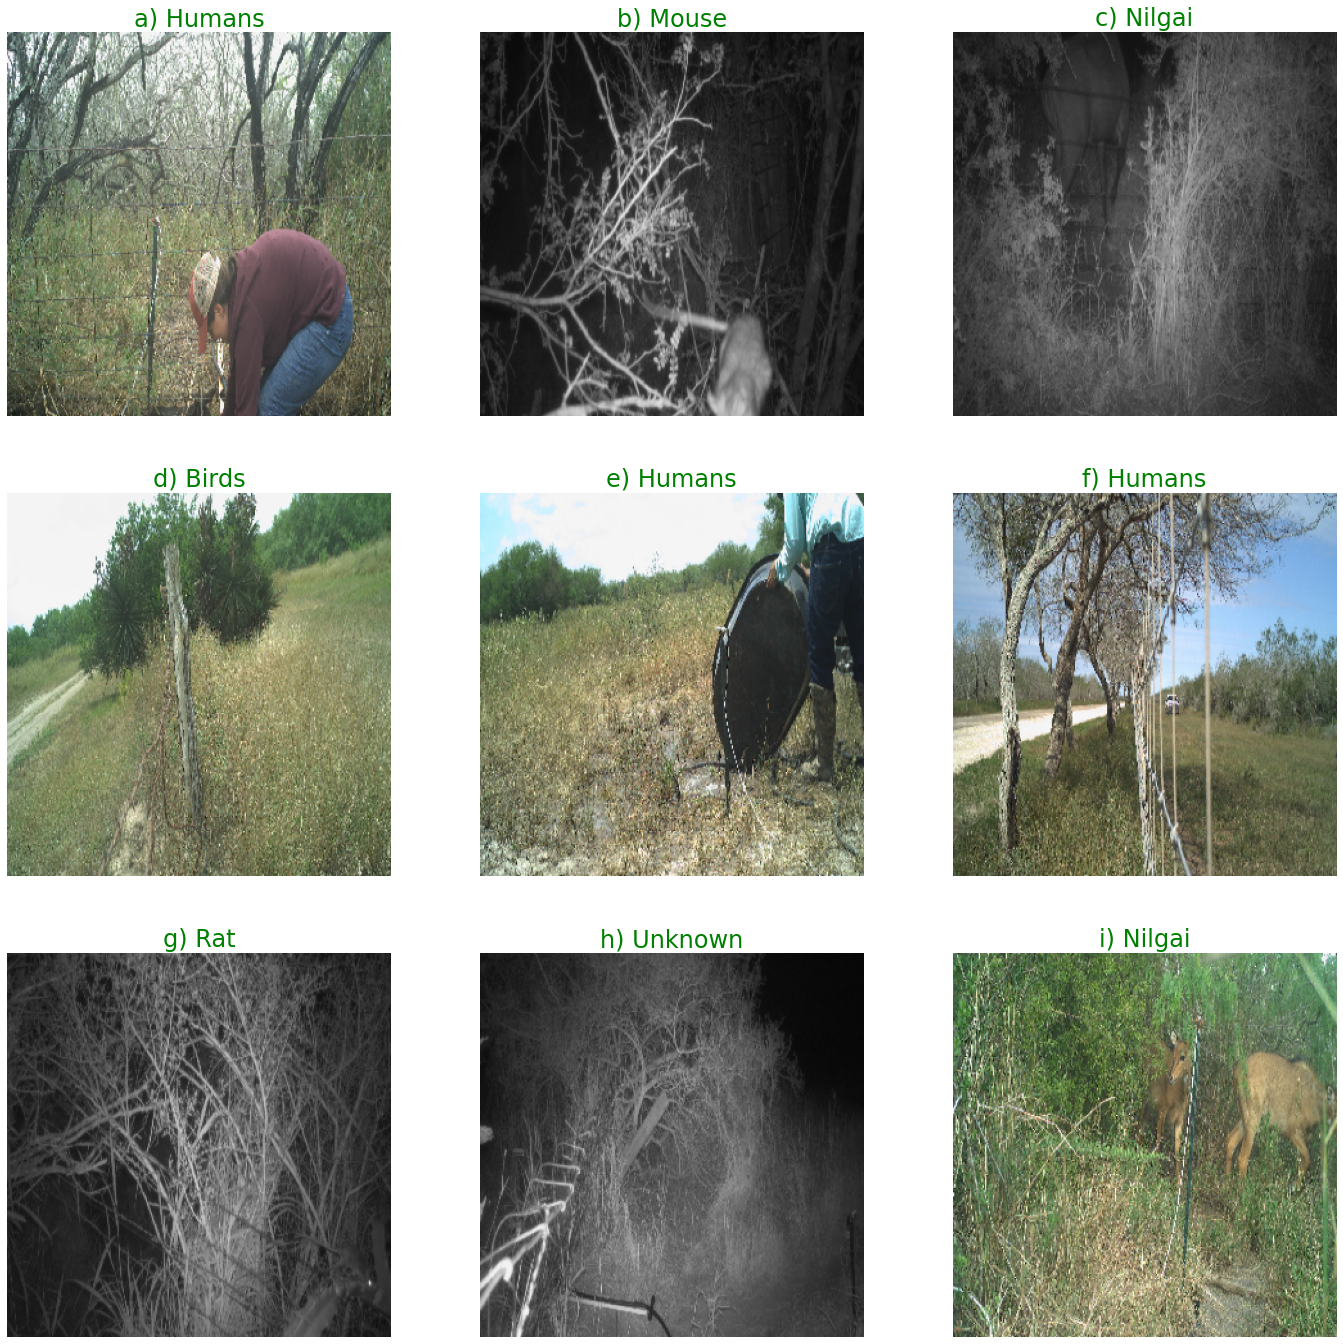

In [23]:
import string
alph = list(string.ascii_lowercase)
%matplotlib inline
def show_batch(image_batch, predicted_id, label_id):
  plt.figure(figsize=(24,24))
  for n in range(9):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image_batch[n])
    if predicted_id[n] == label_id[n]:
      plt.title(alph[n] + ") " + predicted_label_batch[n].title(), color="green", fontsize=24)

    else: 
      plt.title(alph[n] + ") " + "Incorrect Prediction: " + predicted_label_batch[n].title() + "\n Correct = " + str(class_names[label_id[n]]), color="red", fontsize=24)
    
    # ax.set_xlabel(r"$\bf{" + alph[n]  + ")}$", fontsize=18)
    plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# view model predictions
image_batch, label_batch = next(test_generator)
label_id = np.argmax(label_batch, axis=-1)
predicted_batch = model.predict(image_batch, verbose=1, batch_size=BATCH_SIZE,steps=pred_steps, workers=4)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
show_batch(image_batch, predicted_id, label_id)

In [30]:
# plt.figure()
# plt.ylabel("Accuracy")
# plt.xlabel("Training Steps")
# plt.ylim([0,1])
# plt.plot(batch_stats.batch_acc)
# plt.plot(batch_stats.batch_acc)


In [31]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.ylabel("Loss")
# plt.xlabel("Training Steps")
# plt.ylim([0,4])
# plt.plot(batch_stats.batch_losses)

In [32]:
# acc = batch_stats.batch_acc[:]
# val_acc = batch_stats.batch_acc[:]

# loss = batch_stats.batch_losses[:]
# val_loss = batch_stats.batch_losses[:]

# plt.figure(figsize=(14, 14))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,2.1])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [40]:
batch_stats.ba

AttributeError: 'CollectBatchStats' object has no attribute 'ba'